
# 0. 项目介绍

- 项目数据集来自Kaggle网站公开的Hotel booking demand项目。

- 该数据集包含了一家城市酒店和一家度假酒店的预订信息，包括预订时间、入住时间、成人、儿童和/或婴儿数量、可用停车位数量等信息。数据集已进行个人信息脱敏，容量约为12万×32。

本项目主要包含以下内容：

1. 完成对数据集的数据预处理；
2. 利用数据集对酒店运营状况/市场情况/客户画像进行探索性数据分析（回答10个问题）；
3. 根据数据集建立机器学习模型，预测客户是否会取消预定。
4. 评估各特征值权重。

In [23]:
# 导入库
# 常规库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium
import warnings

# 机器学习库
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import eli5 # 用于评估特征重要性

In [24]:
# 设置显示参数
sns.set(style='whitegrid')
pd.set_option('display.max_columns', 36)

warnings.filterwarnings('ignore')

In [3]:
# 加载数据
file_path = './hotel_bookings.csv'
full_data = pd.read_csv(file_path)

In [4]:
full_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [5]:
# 检查是否存在缺失值
data_missing = full_data.isnull().sum()
data_missing[data_missing != 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

替换缺失值：
- agent （提交预定的旅行社ID）: 如果未包含 agent ， 很可能本身就没有旅行社。
- company（提交预定的公司/实体ID） : 如果未包含，则可能是个人订单。

In [6]:
nan_replacements = {'children':0, 'country':'Unknown', 'agent':0, 'company':0}
full_data_cln = full_data.fillna(nan_replacements)

- meal 特征值包含 'Undefined', 这与 'SC' 意思一样。对其进行替换。

In [7]:
print(full_data_cln['meal'].value_counts())

BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: meal, dtype: int64


In [8]:
full_data_cln['meal'].replace('Undefined', 'SC', inplace=True)

In [9]:
# 结果检查
print(full_data_cln['meal'].value_counts())

BB    92310
HB    14463
SC    11819
FB      798
Name: meal, dtype: int64


- 有些订单中，入住人数（成年人、孩子、婴儿的总和）为0，此为异常订单，删除之。

In [10]:
# df.loc[] 中写入的是布尔数组; 取筛选后df的索引值; df.drop() 删除对应行。
zero_guests = full_data_cln.loc[ full_data_cln['adults'] + full_data_cln['children'] + full_data_cln['babies'] == 0 ].index
full_data_cln.drop(zero_guests, inplace=True)

In [11]:
# 数据清洗后的数据行列数
full_data_cln.shape

(119210, 32)

# 1. 探索性数据分析


本节回答以下问题：
- 客户都来自哪些国家？
- 客户预定房间留宿一晚需要花费多少钱？
- 每晚花费金额在各月份之间是怎样变化的？
- 哪个月份酒店生意最好？
- 顾客一般会留宿多久？
- 订单渠道有哪些？
- 有多少订单被取消了？
- 哪个月份的订单取消数最高？

In [19]:
# 经过数据清洗后，将数据分为'度假酒店'和'城市酒店'两个子数据集。
# 为了知道实际的客户数，仅统计未取消订单的客户

rh = full_data_cln.loc[ (full_data_cln['hotel'] == 'Resort Hotel') & (full_data_cln['is_canceled'] == 0)] # df.loc[] 传入的是布尔数据，两个条件：1. 度假酒店；2. 未取消订单。
ch = full_data_cln.loc[ (full_data_cln['hotel'] == 'City Hotel') & (full_data_cln['is_canceled'] == 0)]

## 1.1 客户都来自哪些国家？

In [15]:
# 1. 筛选未取消订单的行，按国家进行分组，并统计订单数。
country_data = pd.DataFrame( full_data_cln.loc[full_data_cln['is_canceled'] == 0]['country'].value_counts() )
# 2. 重命名订单数量列的名称。
country_data.rename(columns={'country':'Number of Guests'}, inplace=True)
total_guests = country_data['Number of Guests'].sum()
# 3. 新建一列，计算各国订单占订单总量的百分比。
country_data['Guests in %'] = round(country_data['Number of Guests'] / total_guests * 100, 2)
# 4. 使用索引新建一列，为所属国家。
country_data['country'] = country_data.index


# 绘制饼图
fig = px.pie(
    country_data,
    values='Number of Guests',
    names='country',
    title='Home country of guests',
    template='seaborn'
)
fig.update_traces(textposition= 'inside', textinfo='value+percent+label')
fig.show()

In [17]:
# 在地图上显示
guest_map = px.choropleth(
    country_data,
    locations=country_data.index,
    color=country_data['Guests in %'], # 按照占比去显示不同的颜色,
    hover_name=country_data.index,
    color_continuous_scale=px.colors.sequential.Plasma,
    title='Home country of guests'
)

guest_map.show()

- 2个酒店的客户来源世界各国。大多数的客户来自葡萄牙和欧洲其他国家。

## 1.2 客户预定房间留宿一晚需要花费多少钱？

- 两个酒店都有不同价格标准的房间和餐食。季节因素影响也很大。因此价格变化会很大。
- 数据中未给出具体货币类型，但因葡萄牙属于欧盟之一，因此猜测本数据集使用的支付货币为欧元。

In [25]:
# 计算分摊人数，只包括成年人和孩子，婴儿不算在内。
rh['adr_pp'] = rh['adr'] / (rh['adults'] + rh['children']) # rh['adr'] 表示客房日均价
ch['adr_pp'] = ch['adr'] / (ch['adults'] + ch['children'])

In [33]:
print("对于所有未取消订单， 忽略房型和餐饮因素， 平均价格为：\n\n 1.度假酒店:{:.2f} €/每人每晚 ; \n 2.城市酒店:{:.2f} €/每人每晚 ;".format(rh['adr_pp'].mean(), ch['adr_pp'].mean()))

对于所有未取消订单， 忽略房型和餐饮因素， 平均价格为：

 1.度假酒店:47.49 €/每人每晚 ; 
 2.城市酒店:59.27 €/每人每晚 ;


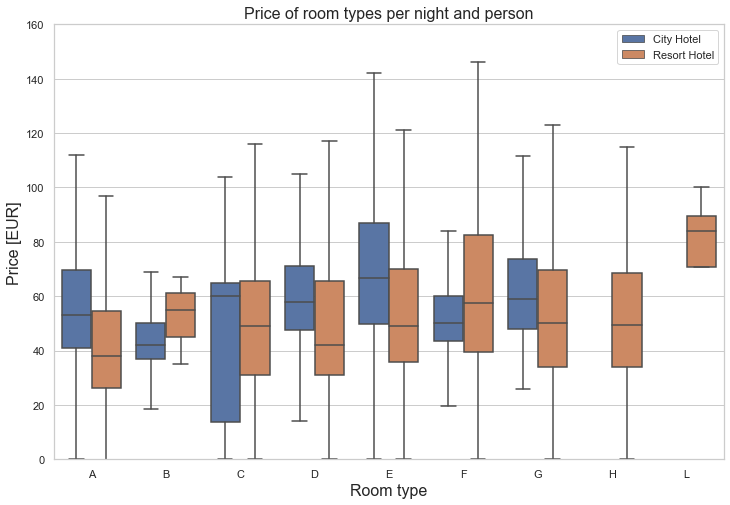

In [39]:
# 在总数据集上探索 
full_data_cln['adr_pp'] = full_data_cln['adr'] / (full_data_cln['adults'] + full_data_cln['children']) # 计算平均花费金额/每人每晚
full_data_guests = full_data_cln.loc[full_data_cln['is_canceled'] == 0] # 仅讨论未取消订单的客户

room_prices = full_data_guests[['hotel', 'reserved_room_type', 'adr_pp']].sort_values('reserved_room_type')


# 绘制箱型图
plt.figure(figsize=(12, 8))
sns.boxplot(
    x='reserved_room_type',
    y='adr_pp',
    hue='hotel',
    data=room_prices,
    hue_order=['City Hotel', 'Resort Hotel'],
    fliersize=0
)

plt.title('Price of room types per night and person', fontsize=16)
plt.xlabel('Room type', fontsize=16)
plt.ylabel('Price [EUR]', fontsize=16)
plt.legend(loc='upper right')
plt.ylim(0, 160)
plt.show()

- 上图显示了每间客房的平均价格（欧元/每人每晚），具体取决于其类型和标准差。

## 1.3 每晚花费金额在各月份之间是怎样变化的？

方便起见，忽略房型和餐食因素，直接计算每人每晚需花费的金额，并研究与月份之间的关系。

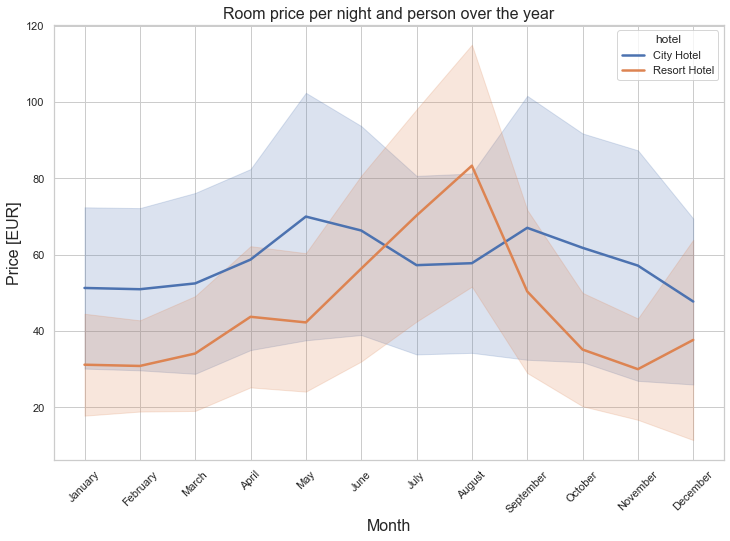

In [48]:
# 获取数据
room_prices_monthly = full_data_guests[['hotel', 'arrival_date_month', 'adr_pp']].sort_values('arrival_date_month') # full_data_guests = full_data_cln.loc[full_data_cln['is_canceled'] == 0] 

# 按月份顺序
orderd_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

room_prices_monthly['arrival_date_month'] = pd.Categorical(room_prices_monthly['arrival_date_month'], categories=orderd_months, ordered=True)

# room_prices_monthly['arrival_date_month'] # Categories (12, object): ['January' < 'February' < 'March' < 'April' ... 'September' < 'October' < 'November' < 'December']

# 绘制折线图
plt.figure(figsize=(12, 8))
sns.lineplot(
    x='arrival_date_month',
    y='adr_pp',
    hue='hotel',
    data=room_prices_monthly,
    hue_order=['City Hotel', 'Resort Hotel'],
    ci='sd',
    size='hotel',
    sizes=(2.5, 2.5)
)
plt.title('Room price per night and person over the year', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()

- 夏季，度假酒店的人均每晚消费金额 > 城市酒店人均每晚消费金额。这符合常识。
- 城市酒店的人均每晚消费金额变化幅度更小，且春秋两季消费更贵。

## 1.4 哪个月份酒店生意最好？

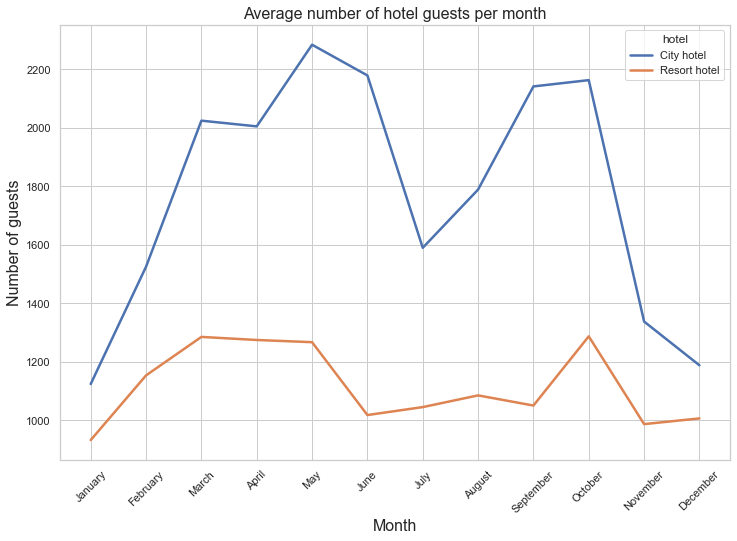

In [64]:
# 创建相关数据的DF

# 1. 创建分组、聚合数据
resort_guests_monthly = rh.groupby('arrival_date_month')['hotel'].count()
city_guests_monthly = ch.groupby('arrival_date_month')['hotel'].count()

# 2. 创建相关df
resort_guest_data = pd.DataFrame(
    {'month':list(resort_guests_monthly.index),
     'hotel':'Resort hotel',
     'guests':list(resort_guests_monthly.values)}
)

city_guest_data = pd.DataFrame(
    {'month':list(city_guests_monthly.index),
     'hotel':'City hotel',
     'guests':list(city_guests_monthly.values)}
)

# 3. 合并两个类型的df
full_guest_data = pd.concat([resort_guest_data, city_guest_data], ignore_index=True)

# 4. 按月份顺序显示
ordered_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

# 5. 转换数据：7、8月份有3年数据，其他月份有2年数据，进行数据处理，转化为年均订单数量。
full_guest_data.loc[ (full_guest_data['month'] == 'July') | (full_guest_data['month'] == 'August'), 'guests'] /= 3  # df.loc[], 传入布尔数组取行数，传入列名取列数。
full_guest_data.loc[ ~((full_guest_data['month'] == 'July') | (full_guest_data['month'] == 'August')), 'guests'] /= 2 


# 6. 绘制图像
plt.figure(figsize=(12, 8))
sns.lineplot(
    x='month',
    y='guests',
    hue='hotel',
    data=full_guest_data,
    hue_order=['City hotel', 'Resort hotel'],
    size='hotel',
    sizes=(2.5, 2.5)
)

plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()




- 对于城市酒店：春秋两季客户数量较多，且售价较高。但七、八月份销量和售价都较低。
- 对于度假酒店：六月至九月份，订单数量轻微下降，而售价却是最高的。
- 对于两类酒店：冬季的订单和价格双低。

## 1.5 顾客一般会留宿多久？

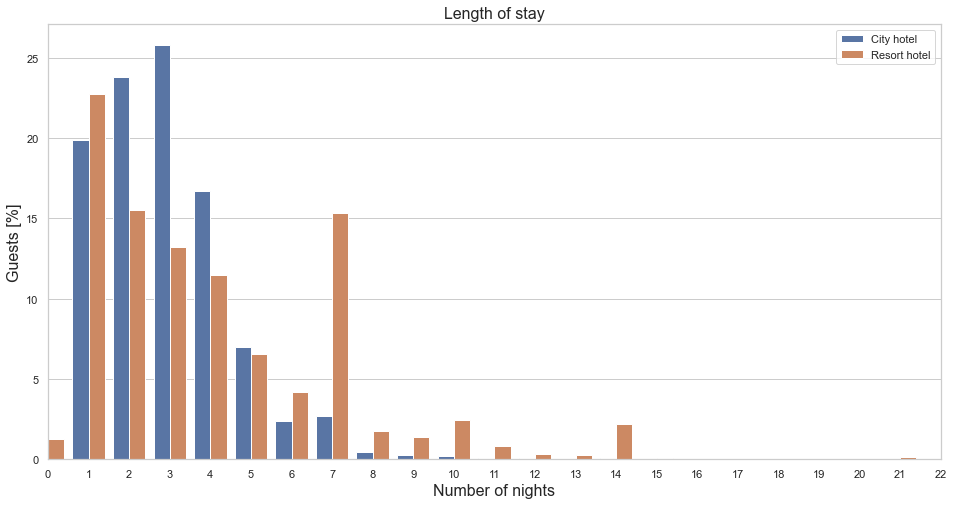

In [66]:
rh['total_nights'] = rh['stays_in_weekend_nights'] + rh['stays_in_week_nights']
ch['total_nights'] = ch['stays_in_weekend_nights'] + ch['stays_in_week_nights']

# 1. 创建分组、聚合数据
# 对于度假酒店
num_nights_res = list(rh['total_nights'].value_counts().index) # 留宿天数
num_bookings_res = list(rh['total_nights'].value_counts()) # 留宿天数对应的客户数
rel_bookings_res = rh['total_nights'].value_counts() / sum(num_bookings_res) * 100 # 留宿天数对应的客户数，占总客户数的比例
# 对于城市酒店
num_nights_cty = list(ch["total_nights"].value_counts().index)
num_bookings_cty = list(ch["total_nights"].value_counts())
rel_bookings_cty = ch["total_nights"].value_counts() / sum(num_bookings_cty) * 100

# 2. 创建相关df
res_nights = pd.DataFrame({"hotel": "Resort hotel", "num_nights": num_nights_res, "rel_num_bookings": rel_bookings_res})
cty_nights = pd.DataFrame({"hotel": "City hotel", "num_nights": num_nights_cty, "rel_num_bookings": rel_bookings_cty})

# 3. 合并两个类型的df
nights_data = pd.concat([res_nights, cty_nights], ignore_index=True)

# 4. 绘制图像
plt.figure(figsize=(16, 8))
sns.barplot(x = "num_nights", y = "rel_num_bookings", hue="hotel", data=nights_data, hue_order = ["City hotel", "Resort hotel"])
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()

In [78]:
# 按占比、留宿天数进行加权平均计算，求出平均数
avg_nights_res = sum(list((res_nights['num_nights'] * (res_nights['rel_num_bookings'] / 100)).values))
avg_nights_cty = sum(list((cty_nights["num_nights"] * (cty_nights["rel_num_bookings"]/100)).values))


print(f"预定城市酒店的客户，平均留宿 {avg_nights_cty:.2f} 晚, 最大值为 {cty_nights['num_nights'].max()} 晚。")
print(f"预定度假酒店的客户，平均留宿 {avg_nights_res:.2f} 晚, 最大值为 {res_nights['num_nights'].max()} 晚。")

预定城市酒店的客户，平均留宿 2.92 晚, 最大值为 48 晚。
预定度假酒店的客户，平均留宿 4.14 晚, 最大值为 69 晚。


- 对于城市酒店，预定1至4晚的订单占比多。
- 对于度假酒店，预定1至4晚的订单占比同样多，但预定7晚的订单数占比同样不少。

## 1.6 订单渠道有哪些？

In [84]:
# 每个渠道的订单数有多少？（包含了取消的订单）

segments = full_data_cln['market_segment'].value_counts()

# 绘制饼图
fig = px.pie(
    segments,
    values=segments.values,
    names=segments.index,
    title='Booking per market segment',
    template='seaborn'
)

fig.update_traces(rotation=-90, textinfo='percent+label')
fig.show()

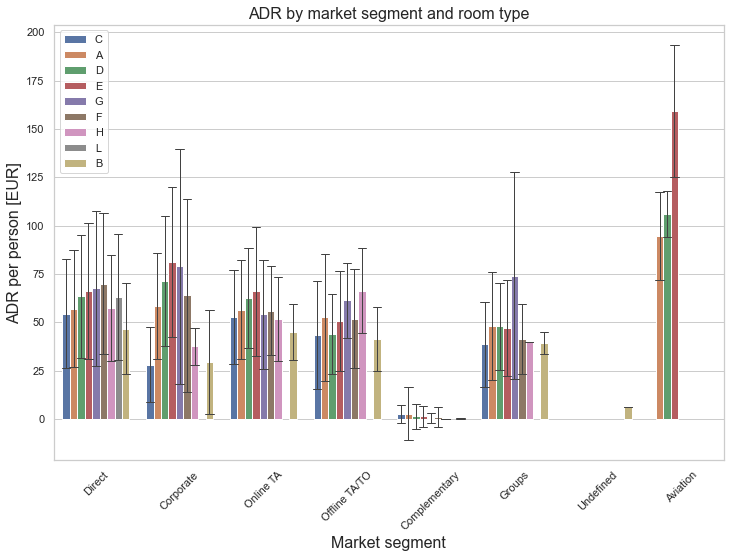

In [85]:
# 不同渠道、房型对应的人均每晚消费金额

plt.figure(figsize=(12, 8))
sns.barplot(
    x='market_segment',
    y='adr_pp',
    hue='reserved_room_type',
    data=full_data_cln,
    ci='sd',
    errwidth=1,
    capsize=0.1
)

plt.title("ADR by market segment and room type", fontsize=16)
plt.xlabel("Market segment", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("ADR per person [EUR]", fontsize=16)
plt.legend(loc="upper left")
plt.show()

- 团购渠道拿到的价格最低。而航空公司支付的房价最高，几乎超过团队渠道价格的2倍。

In [87]:
Airline_data = full_data_cln.loc[ full_data_cln['market_segment'] == 'Aviation'][['is_canceled', 'adults', 'lead_time', 'adr_pp']].describe()

Non_Airline_data = full_data_cln.loc[ full_data_cln['market_segment'] != 'Aviation'][['is_canceled', 'adults', 'lead_time', 'adr_pp']].describe()

In [88]:
Airline_data

,is_canceled,adults,lead_time,adr_pp
count,235.000000,235.000000,235.00000,235.000000
mean,0.221277,1.012766,4.47234,100.270979
std,0.415992,0.112503,4.61629,20.376689
min,0.000000,1.000000,0.00000,0.000000
25%,0.000000,1.000000,1.00000,95.000000
50%,0.000000,1.000000,3.00000,95.000000
75%,0.000000,1.000000,6.00000,110.000000
max,1.000000,2.000000,23.00000,193.500000


In [89]:
Non_Airline_data

,is_canceled,adults,lead_time,adr_pp
count,118975.000000,118975.000000,118975.000000,118975.000000
mean,0.371061,1.860878,104.306031,55.036835
std,0.483091,0.574499,106.888885,29.017596
min,0.000000,0.000000,0.000000,-3.190000
25%,0.000000,2.000000,18.000000,37.440000
50%,0.000000,2.000000,69.000000,49.500000
75%,1.000000,2.000000,161.000000,66.000000
max,1.000000,55.000000,737.000000,2700.000000


- 航空公司的预订提前期非常短，平均只有4天。而其他渠道预订提前期平均为104天。
- 航空公司需要一个供机组人员住宿的地方。
- 航空公司的员工通常每人住一个房间。而家庭住宿通常合住。

## 1.7 有多少订单被取消了？

In [90]:
# 总订单取消数
total_cancelations = full_data_cln['is_canceled'].sum()

# 度假酒店取消数 、 城市酒店取消数
rh_cancelations = full_data_cln.loc[full_data_cln['hotel'] == 'Resort Hotel']['is_canceled'].sum()
ch_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"]["is_canceled"].sum()


# 总订单取消比例
rel_cancel = total_cancelations / full_data_cln.shape[0] * 100
# 度假酒店订单取消比例
rh_rel_cancel = rh_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"].shape[0] * 100
# 城市酒店订单取消比例
ch_rel_cancel = ch_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"].shape[0] * 100


print(f"总订单取消数 / 占比: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"度假酒店订单取消数 / 占比: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"城市酒店订单取消数 / 占比: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

总订单取消数 / 占比: 44,199 (37 %)
度假酒店订单取消数 / 占比: 11,120 (28 %)
城市酒店订单取消数 / 占比: 33,079 (42 %)


## 1.8 哪个月份的订单取消数最高？

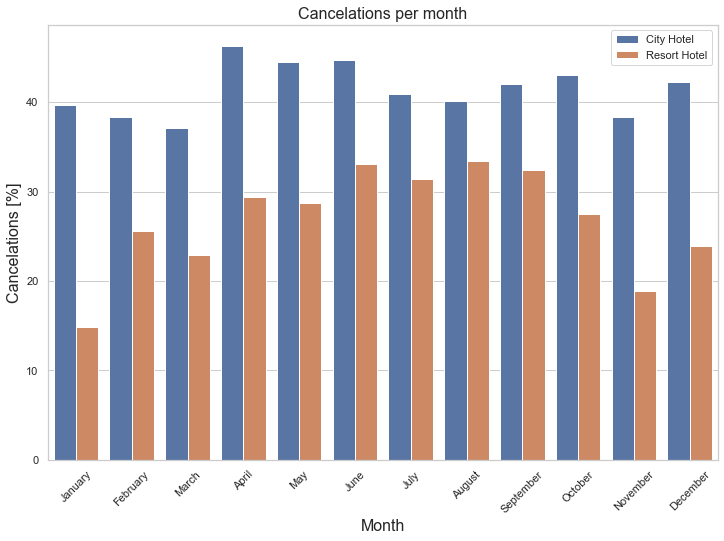

In [91]:
# 度假酒店每月订单数
res_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
# 度假酒店每月订单取消数
res_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()


# 城市酒店每月订单数
cty_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
# 城市酒店每月订单取消数
cty_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()


# 创建df， 对应的是 酒店类型、月份、订单数、取消订单数
res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

# 合并df
full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
# 计算每月订单取消比例（当月订单取消数 / 当月总订单数）
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

# 按月份排序
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
# 转换类型
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

# 绘制条形图
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

- 对于城市酒店，全年订单取消率大约都在40%左右。
- 对于度假酒店，夏季订单取消率最高、冬季订单取消率最低。

# 2. 预测模型建立

- 哪些连续型特征对是否取消预定影响最大？

In [93]:
cancel_corr = full_data_cln.corr()['is_canceled']
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.292876
total_of_special_requests         0.234877
required_car_parking_spaces       0.195701
booking_changes                   0.144832
previous_cancellations            0.110139
is_repeated_guest                 0.083745
company                           0.083594
adults                            0.058182
previous_bookings_not_canceled    0.057365
days_in_waiting_list              0.054301
agent                             0.046770
adr                               0.046492
babies                            0.032569
stays_in_week_nights              0.025542
adr_pp                            0.017808
arrival_date_year                 0.016622
arrival_date_week_number          0.008315
arrival_date_day_of_month         0.005948
children                          0.004851
stays_in_weekend_nights           0.001323
Name: is_canceled, dtype: float64

- lead_time、total_of_special_requests、required_car_parking_space、booking_changes和previous_cancelations是5个最为相关的连续型特征值。
- the number of booking changes（预定更改次数） 特征值将随时间发生变化，模型训练时不用这个特征值。days_in_waiting_list（客户确认预定前的等待天数） and arrival_date_year（预定到店年份）。
- 最重要的是要排除 reservation_status（最终预定状态） 这个特征值。

In [98]:
full_data_cln.groupby('is_canceled')['reservation_status'].value_counts()

is_canceled  reservation_status
0            Check-Out             75011
1            Canceled              42993
             No-Show                1206
Name: reservation_status, dtype: int64

对比不同的模型。

In [103]:
# 手动选择特征值
# 为了使得模型更加通用，且防止预测信息泄露，排除了一些特征值 ： 
# (arrival_date_year, assigned_room_type, booking_changes, reservation_status, country, days_in_waiting_list)
# 尽管包含 country 特征值，可能会提高精准性。但同时也会使得模型通用性降低，综合考虑排除之。

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]


cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# 分离特征值和目标值
fatures = num_features + cat_features
X = full_data_cln.drop(['is_canceled'], axis=1)[fatures]
y = full_data_cln['is_canceled']

In [105]:
# 处理数值型特征值：
# 对于除日期以外的大多数列，0是最符合逻辑的填充值。
# 数据集中没有缺失值。
num_transformer = SimpleImputer(strategy='constant')

# 处理类别型特征值
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# 同时处理数值型、类别型特征值
# (名称，处理器，作用于哪些列)
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])


In [106]:
# 定义测试模型
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),               # 决策树
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),     # 随机森林
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),         # 逻辑回归
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]            # XGB


# 将数据分割为K折，目的是为了执行交叉验证
# 使用 shuffle 功能，确保数据随机分布

kfolds = 4 # 75%的数据用于训练，25%的数据用于验证
split = KFold(n_splits=kfolds, shuffle=True, random_state=42) # shuffle : 布尔值, 默认为False。表示是否要将数据打乱顺序后再进行划分。如果样本原始的排列是有特定顺序的，不打乱就进行交叉验证，可能会对结果产生影响。

In [108]:
# 对每个模型进行预处理、拟合、预测和评分
for name, model in base_models:
    # 利用管道，对数据进行预处理，然后传入模型
    model_steps = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # 针对每个模型，获取交叉验证后的分数
    cv_results = cross_val_score(
        model_steps, # 模型
        X,
        y,
        cv=split, # 四折交叉验证
        scoring='accuracy',
        n_jobs=-1
    )

    # 输出分数
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)

    print(f"{name} 交叉验证后的准确率为: {mean_score} +/- {std_dev} (标准差) 最低分: {min_score}, 最高分: {max_score}")

DT_model 交叉验证后的准确率为: 0.8259 +/- 0.0008 (标准差) 最低分: 0.8248, 最高分: 0.827
RF_model 交叉验证后的准确率为: 0.8667 +/- 0.0008 (标准差) 最低分: 0.8659, 最高分: 0.8681
LR_model 交叉验证后的准确率为: 0.7944 +/- 0.003 (标准差) 最低分: 0.7912, 最高分: 0.7982
XGB_model 交叉验证后的准确率为: 0.8468 +/- 0.0011 (标准差) 最低分: 0.8455, 最高分: 0.8483


- 随机森林算法表现最好。
- 进行超参数微调，但准确率的提升有限。

In [109]:
rf_model_enh = RandomForestClassifier(
    n_estimators=160,
    max_features=0.4,
    min_samples_split=2,
    n_jobs=-1,
    random_state=0
)


split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model_enh)])


cv_results = cross_val_score(model_pipe, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)


min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"调优后随机森林模型的准确率为 : {mean_score} +/- {std_dev} (标准差) 最低分: {min_score}, 最高分: {max_score}")

调优后随机森林模型的准确率为 : 0.8676 +/- 0.0009 (标准差) 最低分: 0.8664, 最高分: 0.8684


# 3. 模型特征值重要性评估

In [110]:
# 使用管道对模型进行训练，以便可以获取相关数据值
model_pipe.fit(X, y) # rf_model_enh

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['lead_time',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'agent', 'company',
                                                   'r...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hotel',
                                                   'arrival_date_month', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'deposit_type',
                                                   'customer_type'])])),
                ('model',
                 RandomForestClassifier(max_features=0.4, n_estimators=160,
                                        n_jobs=-1, random_state=0))])

In [120]:
# 需要所有的、one-hot编码后的特征值
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))


# 添加数值型特征值
# 注意顺序：数值型特征值在前
feat_imp_list = num_features + onehot_columns


In [124]:
#  显示前10个对取消订单影响最深远的特征值
feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list
)

In [125]:
feat_imp_df.head(10)

,feature,weight,std
0,lead_time,0.146662,0.015429
1,deposit_type_Non Refund,0.144410,0.104293
2,adr,0.095883,0.003540
3,arrival_date_day_of_month,0.069530,0.002063
4,deposit_type_No Deposit,0.068087,0.099340
5,arrival_date_week_number,0.053693,0.002527
6,total_of_special_requests,0.050826,0.011110
7,agent,0.042553,0.005336
8,stays_in_week_nights,0.041500,0.002232
9,previous_cancellations,0.040826,0.014164


TOP 3 权重指标：
- lead_time
- deposit_type
- adr

#### lead_time：


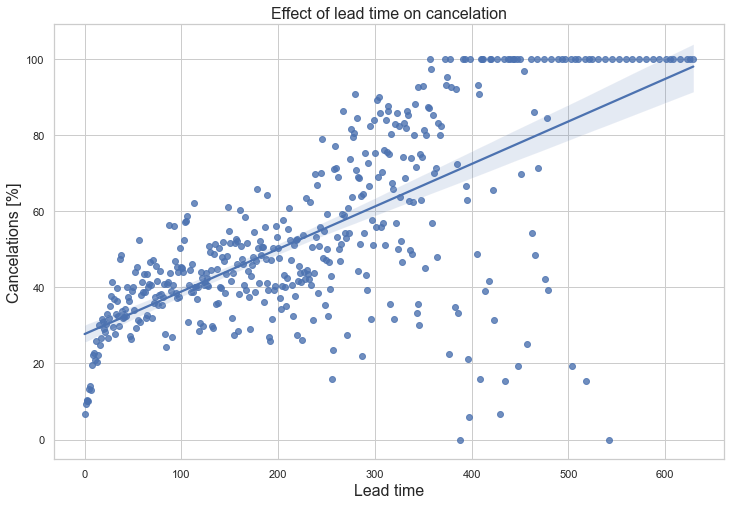

In [127]:
# 按 lead_time 进行分组
lead_cancel_data = full_data_cln.groupby('lead_time')['is_canceled'].describe()

# 只筛选超过10个订单数的 lead_time 组
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data['count'] >= 10]

# 绘制图像 ： x轴为提前预定时间，y轴为取消率。 即 提前预定时间 - 取消率 曲线。
plt.figure(figsize=(12, 8))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()

- 在抵达日期前几天进行的预订很少被取消，而提前一年以上进行的预订经常被取消。

#### Deposit type:

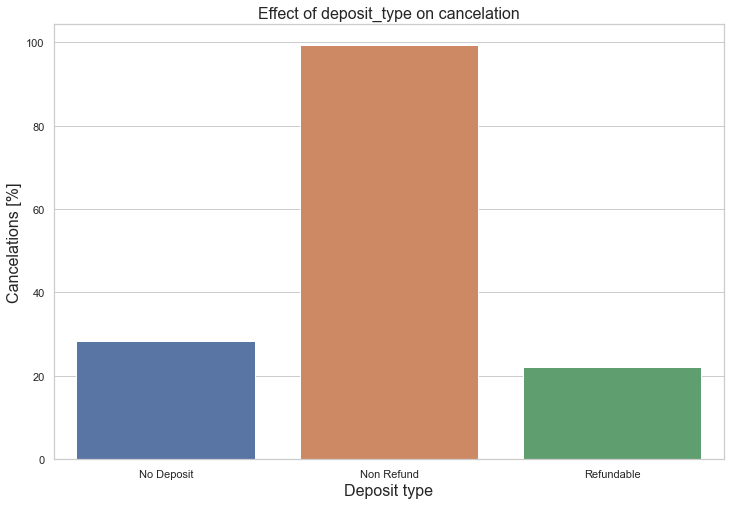

In [130]:
deposit_cancel_data = full_data_cln.groupby("deposit_type")["is_canceled"].describe()


plt.figure(figsize=(12, 8))
sns.barplot(x=deposit_cancel_data.index, y=deposit_cancel_data["mean"] * 100)
plt.title("Effect of deposit_type on cancelation", fontsize=16)
plt.xlabel("Deposit type", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()

- deposit_type 为 Non Refund 和 “is_canceled” 列以反直觉的方式关联。

- 超过99%的预付款的人取消了预订。这就提出了一个问题，即数据（或描述）是否有问题。

In [131]:
deposit_mean_data = full_data_cln.groupby("deposit_type").mean()
deposit_mean_data

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,adr_pp
deposit_type,,,,,,,,,,,,,,,,,,,,,
No Deposit,0.284020,88.841951,2016.173950,27.133208,15.815223,0.969615,2.555633,1.865806,0.118599,0.009085,0.035295,0.042044,0.154938,0.247030,78.745503,11.175874,1.518040,103.685436,0.071184,0.651726,55.231806
Non Refund,0.993624,212.908891,2016.031466,27.448619,15.595462,0.621718,2.091109,1.811407,0.000617,0.000000,0.004387,0.411462,0.010626,0.012477,47.480016,6.215809,7.992253,89.964017,0.000069,0.001782,54.520286
Refundable,0.222222,152.098765,2016.141975,20.932099,23.456790,0.975309,2.851852,1.907407,0.030864,0.000000,0.024691,0.000000,0.018519,0.592593,56.185185,133.666667,9.586420,76.209753,0.123457,0.141975,41.444239


将 “Non refund” 与 “No Deposit” 的平均值进行比较，结果如下：


- Non Refund deposits 的特点是 lead_time 延长2倍以上。（提前很多天就预定了。）

- is_repeated_guest 约为1/10。 （几乎都不是回头客。）

- previous_cancellations 高出10倍以上。 （反复预定、取消。）

- previous_bookings_not_canceled 是1/15。 （预定了之后，很少不取消。）

- required_car_parking_spaces 几乎为零。 （无需车位。）

- special requests 很少。 （几乎不需要什么特别服务。）

基于上述发现，可能是那些并没有去过其中一家酒店的人干的，他们会反复预订、付款和取消。

#### ADR:


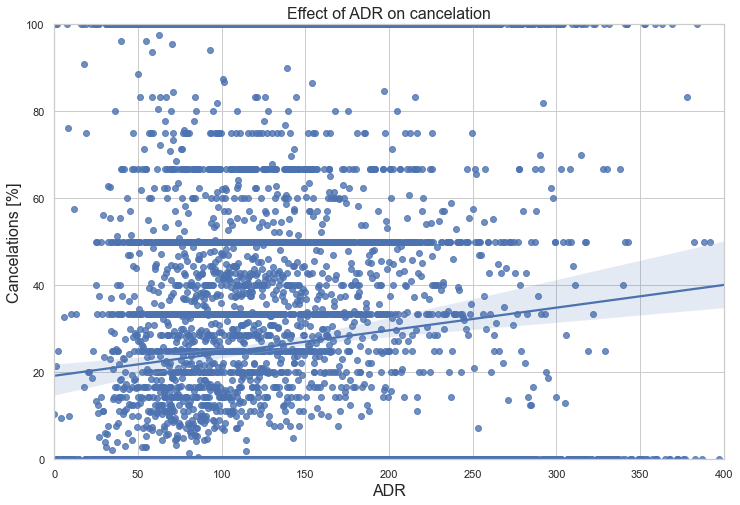

In [133]:
# 横轴为客房日均价；纵轴为取消率。即绘制 客房日均价 - 取消率 之间的曲线图。

adr_cancel_data = full_data_cln.groupby("adr")["is_canceled"].describe()


plt.figure(figsize=(12, 8))
sns.regplot(x=adr_cancel_data.index, y=adr_cancel_data["mean"].values * 100)
plt.title("Effect of ADR on cancelation", fontsize=16)
plt.xlabel("ADR", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.xlim(0,400)
plt.ylim(0,100)
plt.show()

#### RF model without deposit type:

In [135]:
cat_features_non_dep = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","customer_type"]

features_non_dep = num_features + cat_features_non_dep
X_non_dep = full_data.drop(["is_canceled"], axis=1)[features_non_dep]



preprocessor_non_dep = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features_non_dep)])


X_non_dep = full_data_cln.drop(["is_canceled"], axis=1)[features_non_dep]

rf_model_non_dep = RandomForestClassifier(random_state=42) 

kfolds=4
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor_non_dep),
                              ('model', rf_model_non_dep)])
cv_results = cross_val_score(model_pipe, 
                                 X_non_dep, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)

min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"无 deposit_type 特征值的随机森林模型，交叉验证评估准确率分数为: {mean_score} +/- {std_dev} (标准差) 最低分: {min_score}, 最高分: {max_score}")

无 deposit_type 特征值的随机森林模型，交叉验证评估准确率分数为: 0.8662 +/- 0.0006 (标准差) 最低分: 0.8654, 最高分: 0.8671


In [136]:
# 原始模型下的重要特征值
feat_imp_df.head(10)


,feature,weight,std
0,lead_time,0.146662,0.015429
1,deposit_type_Non Refund,0.144410,0.104293
2,adr,0.095883,0.003540
3,arrival_date_day_of_month,0.069530,0.002063
4,deposit_type_No Deposit,0.068087,0.099340
5,arrival_date_week_number,0.053693,0.002527
6,total_of_special_requests,0.050826,0.011110
7,agent,0.042553,0.005336
8,stays_in_week_nights,0.041500,0.002232
9,previous_cancellations,0.040826,0.014164


In [137]:
# 新模型下的重要特征值
model_pipe.fit(X_non_dep,y)


onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features_non_dep))


feat_imp_list = num_features + onehot_columns


feat_imp_df_non_dep = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)

In [138]:
# 新模型下的重要特征值:显示TOP10
feat_imp_df_non_dep.head(10)

,feature,weight,std
0,lead_time,0.172700,0.020033
1,adr,0.111006,0.006795
2,total_of_special_requests,0.077629,0.012427
3,arrival_date_day_of_month,0.076399,0.002958
4,arrival_date_week_number,0.060364,0.003916
5,agent,0.053749,0.009322
6,stays_in_week_nights,0.049094,0.003966
7,previous_cancellations,0.048949,0.016884
8,stays_in_weekend_nights,0.030984,0.002859
9,customer_type_Transient,0.029824,0.019587


- 新模型准确率平均为0.8662。
- 该准确率得分几乎与包括 deposit_type 特征值的原始模型情获得的准确率得分相同（0.8676）。
- 新模型通过增加 lead_time、adr、total_of_special_requests 等权重来弥补分数。